In [1]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from main.operators import *
from main.VarQFT import *
from main.circuits import *

np.random.seed(0)

We consider two hydrogen atoms at positions $R$ and $-R$,
$$ H =  P_1^2 + P_2^2 - \frac{1}{|X_1-R|} - \frac{1}{|X_1+R|} - \frac{1}{|X_2-R|} - \frac{1}{|X_2+R|} + \frac{1}{|X_1-X_2|}$$

as always, we have the contribution of the kinetic energy, $P_1^2$ and $P_2^2$. The negative tems come from the Coulombian interaction between electrons and nuclei, and the last term is due to electron-electron interaction.

We start by setting the device to run the simulation

In [2]:
num_wires = 3  # qubits per subsystem
device = qml.device("lightning.qubit", wires=2 * num_wires)

and the Hamiltonian specified above,

In [3]:
wires1 = range(num_wires)
wires2 = range(num_wires, 2 * num_wires)

xrange = 5
X1, P1 = X_and_P_ops(range(num_wires), -xrange, xrange)
X2, P2 = X_and_P_ops(range(num_wires, 2 * num_wires), -xrange, xrange)

I1 = qml.Identity(wires1)
I2 = qml.Identity(wires2)

R = 0.25

H2 = [
    P1.pow(2),
    P2.pow(2),
    addition(X1, qml.s_prod(-R, I1), abs=True).pow(-1).s_prod(-1),
    addition(X1, qml.s_prod(R, I1), abs=True).pow(-1).s_prod(-1),
    addition(X2, qml.s_prod(-R, I2), abs=True).pow(-1).s_prod(-1),
    addition(X2, qml.s_prod(R, I2), abs=True).pow(-1).s_prod(-1),
    distance(X1, X2).pow(-1),
]
H2

[<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4, 5]>]

We compute the eigenvalues and eigenstates in matrix representation using numpy for the sake of results verification

In [4]:
H2_matrix = tomatrix(H2)

vals, vecs = np.linalg.eigh(H2_matrix)
vec = vecs[:, 0]
vals[0:2]

array([-3.47576857, -3.34757394])

We define the variational ansatz, taking advantage of the symmetry of the system

In [5]:
num_layers = 10
circuit_def = RY_ansatz(
    2 * num_wires - 1, num_layers
)  # 1 qubit less before symmetrization
num_params = circuit_def.num_params

# (anti) symmetrization
ansatz_sym = symmetric_ansatz(circuit_def, antisymmetric=False)
var_state_sym = ansatz_sym.construct_circuit

ansatz_asym = symmetric_ansatz(circuit_def, antisymmetric=True)
var_state_asym = ansatz_asym.construct_circuit

### Ground state

Since the atoms have a large overlap, the more stable configuration is expected to be antisymmetric in this case. Thus, we define the instance of `VarFourier` with the antisymmetric ansatz to find the ground state.

In [6]:
varqft = VarFourier(H2, device, var_state_asym)

We run the optimization problem,

In [7]:
print(f"Optimal energy: {vals[0]:12.6f}")

params = 1e-3 * np.random.randn(num_params)

Params_ground, Energies_ground = varqft.run(params, max_iterations=500)

Optimal energy:    -3.475769
Step:    500, Energy:    -3.437073


and we have found the ground state!

Best energy:    -3.470074


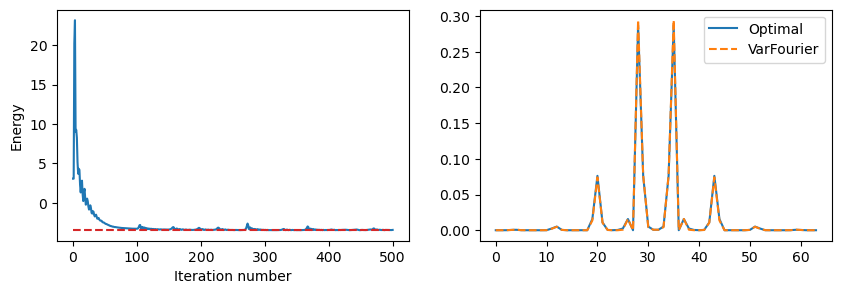

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

min_index = np.argmin(Energies_ground)
print(f"Best energy: {Energies_ground[min_index]:12.6f}")
ground_state = varqft.state(Params_ground[min_index])

ax[0].plot(Energies_ground)
ax[0].hlines(vals[0], 0, len(Energies_ground), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ax[1].plot(np.abs(vecs[:, 0]) ** 2)
ax[1].plot(np.abs(ground_state) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"], loc="best")

In [9]:
fidelity = np.abs(np.vdot(ground_state, vecs[:, 0])) ** 2
fidelity

0.9978181381322134

As before, the state has the space information mixed up. We can separate it, and make a plot on the configuration space

Text(0.5, 1.0, 'Ground state probability density')

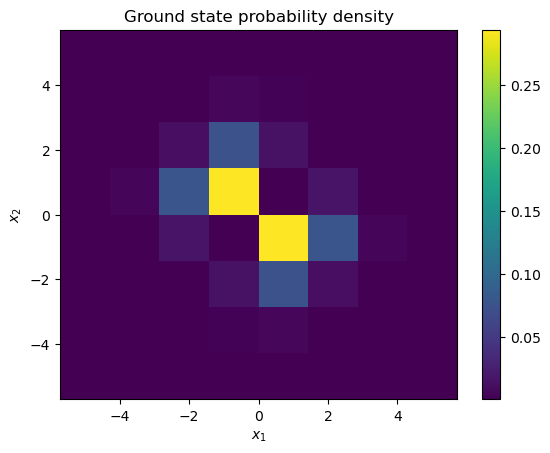

In [10]:
Mg = ground_state.reshape(2**num_wires, 2**num_wires)

plt.pcolormesh(X1.eigvals(), X2.eigvals(), np.abs(Mg) ** 2)
plt.colorbar()
plt.xlabel("$ x_1 $")
plt.ylabel("$ x_2 $")
plt.title("Ground state probability density")

### Excited state

We can repeat the process with a symmetric ansatz and we will find the first excited state,

In [11]:
varqft.set_var_state(var_state_sym)  # Set Symmtric ansatz

print(f"Optimal energy: {vals[1]:12.6f}")
Params_excited, Energies_excited = varqft.run(params, max_iterations=500)

Optimal energy:    -3.347574
Step:    500, Energy:    -3.327600


Best energy:    -3.340210


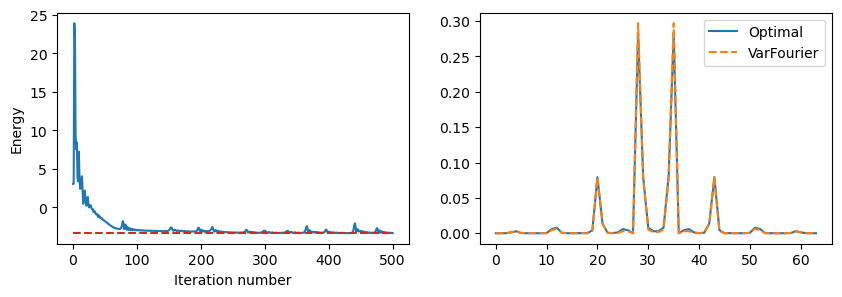

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

min_index = np.argmin(Energies_excited)
print(f"Best energy: {Energies_excited[min_index]:12.6f}")
excited_state = varqft.state(Params_excited[min_index])

ax[0].plot(Energies_excited)
ax[0].hlines(vals[1], 0, len(Energies_excited), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ax[1].plot(np.abs(vecs[:, 1]) ** 2)
ax[1].plot(np.abs(excited_state) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"], loc="best")

In [13]:
fidelity = np.abs(np.vdot(excited_state, vecs[:, 1])) ** 2
fidelity

0.9957721716026608

Text(0.5, 1.0, 'Excited state probability density')

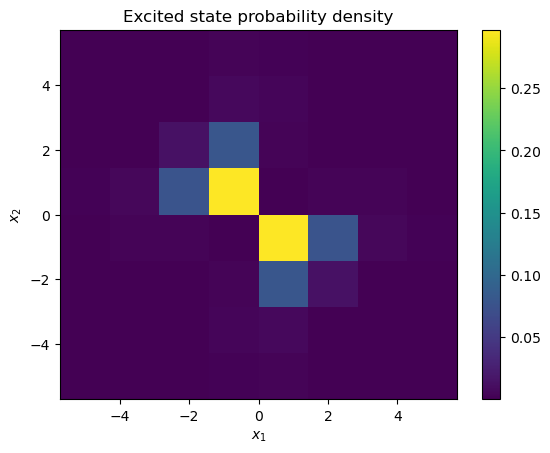

In [14]:
Me = excited_state.reshape(2**num_wires, 2**num_wires)

plt.pcolormesh(X1.eigvals(), X2.eigvals(), np.abs(Me) ** 2)
plt.colorbar()
plt.xlabel("$ x_1 $")
plt.ylabel("$ x_2 $")
plt.title("Excited state probability density")

Note, that this state is very similar to the ground state, but its symmetry is inverted

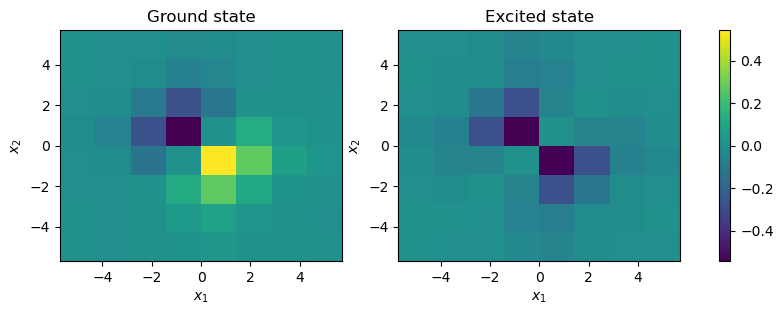

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

minc = min(Mg.real.min(), Me.real.min())
maxc = max(Mg.real.max(), Me.real.max())

im = ax[0].pcolormesh(X1.eigvals(), X2.eigvals(), Mg.real, clim=(minc, maxc))
ax[0].set_title("Ground state")
ax[0].set_xlabel("$ x_1 $")
ax[0].set_ylabel("$ x_2 $")

ax[1].pcolormesh(X1.eigvals(), X2.eigvals(), Me.real, clim=(minc, maxc))
ax[1].set_title("Excited state")
ax[1].set_xlabel("$ x_1 $")
ax[1].set_ylabel("$ x_2 $")

fig.colorbar(im, ax=ax)